<a href="https://colab.research.google.com/github/kaylawwong/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Classification of Fresh VS Spoiled Produce Using YOLO <b> </h1></center>

Importing required Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Description






Fruit Images for Classification

Available => https://data.mendeley.com/datasets/xkbjx8959c/2

- 5 different fruits:

    - Apple

    - Banana

    - Orange

    - Grape

    - Mango


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO


## Heirarchy of Folders correction

Defining paths to train and test folders.



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

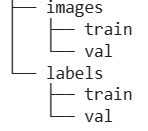


Making directories according to above struture of folders

In [ ]:
import os, shutil, random

#paths
base_dir = ('/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset')
source_dir = ('/content/drive/MyDrive/IAT 360 Computer Vision Project/all_images')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

#class folders - same as google drive
classes = [
    'apple_fresh', 'apple_rotten',
    'banana_fresh', 'banana_rotten',
    'orange_fresh', 'orange_rotten',
    'grape_fresh', 'grape_rotten',
    'mango_fresh', 'mango_rotten'
]

#create new folder structure for yolo
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# split and copy (for training and validating)
split_ratio = 0.7 #70% train, 30% validating

for cls in classes:
  src_folder = os.path.join(source_dir, cls)
  images = os.listdir(src_folder)
  random.shuffle(images)

  split = int(len(images) * split_ratio)
  train_images = images[:split]
  val_images = images[split:]

  #copy to train and validatig folders
  for img in train_images:
    shutil.copy(os.path.join(src_folder, img), os.path.join(train_dir, cls))
  for img in val_images:
    shutil.copy(os.path.join(src_folder, img), os.path.join(val_dir, cls))

In [ ]:
import os
import shutil
import random

#paths
base_dir = ('/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset')
source_dir = ('/content/drive/MyDrive/IAT 360 Computer Vision Project/all_images')

#YOLO folder structure
yolo_dir = os.path.join(base_dir, 'YOLO_ready')
train_img_dir = os.path.join(yolo_dir, 'images/train')
val_img_dir = os.path.join(yolo_dir, 'images/val')
train_lbl_dir = os.path.join(yolo_dir, 'labels/train')
val_lbl_dir = os.path.join(yolo_dir, 'labels/val')

#class folders - same as google drive
classes = [
    'apple_fresh', 'apple_rotten',
    'banana_fresh', 'banana_rotten',
    'orange_fresh', 'orange_rotten',
    'grape_fresh', 'grape_rotten',
    'mango_fresh', 'mango_rotten'
]

#mapping class names to YOLO class IDs
class_map = {cls: idx for idx, cls in enumerate(classes)}

#create YOLO folders
for folder in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(folder, exist_ok=True)

# split and copy
split_ratio = 0.7 #70% train, 30% validating

for cls in classes:
    src_folder = os.path.join(source_dir, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    split = int(len(images) * split_ratio)
    train_images = images[:split]
    val_images = images[split:]

    #copy images to YOLO image folders
    for img in train_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(train_img_dir, img))
    for img in val_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(val_img_dir, img))

    #create YOLO labels
    for img in train_images:
        label_path = os.path.join(train_lbl_dir, os.path.splitext(img)[0] + '.txt')
        class_id = class_map[cls]
        #full image bounding box (center_x, center_y, width, height) in YOLO format
        label_line = f"{class_id} 0.5 0.5 1.0 1.0\n"
        with open(label_path, 'w') as f:
            f.write(label_line)

    for img in val_images:
        label_path = os.path.join(val_lbl_dir, os.path.splitext(img)[0] + '.txt')
        class_id = class_map[cls]
        label_line = f"{class_id} 0.5 0.5 1.0 1.0\n"
        with open(label_path, 'w') as f:
            f.write(label_line)

print("YOLO dataset ready")
print(f"Images: {len(os.listdir(train_img_dir))} train, {len(os.listdir(val_img_dir))} val")
print(f"Labels: {len(os.listdir(train_lbl_dir))} train, {len(os.listdir(val_lbl_dir))} val")

YOLO dataset ready
Images: 4838 train, 2083 val
Labels: 4838 train, 2083 val


# **Visualizing some pictures from the dataset**

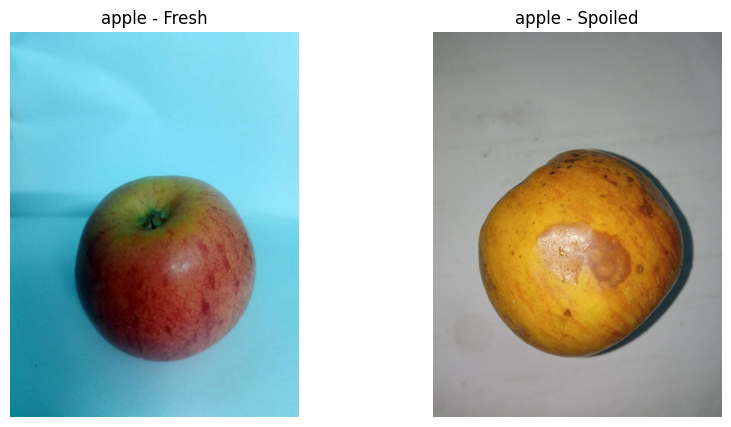

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

fruit = "apple" #can be changed to any fruit in the dataset to visualize

#paths for fresh and spoiled
fresh_path = os.path.join(train_dir, f"{fruit}_fresh")
spoiled_path = os.path.join(train_dir, f"{fruit}_rotten")

#randomly select 1 image from each
fresh_image = random.choice(os.listdir(fresh_path))
spoiled_image = random.choice(os.listdir(spoiled_path))

#load image
img_fresh = cv2.imread(os.path.join(fresh_path, fresh_image))
img_spoiled = cv2.imread(os.path.join(spoiled_path, spoiled_image))

img_fresh = cv2.cvtColor(img_fresh, cv2.COLOR_BGR2RGB)
img_spoiled = cv2.cvtColor(img_spoiled, cv2.COLOR_BGR2RGB)

#plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_fresh)
plt.title(f"{fruit} - Fresh")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_spoiled)
plt.title(f"{fruit} - Spoiled")
plt.axis('off')

plt.show()

# Custom object detection using YOLO

First install and import

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/107.7 GB disk)


In [ ]:
from ultralytics import YOLO

## Training YOLO for Classification

In [ ]:
model = YOLO('yolov8s.pt') # pretrained model

In [ ]:
%%writefile data.yaml
train: /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/YOLO_ready/images/train
val: /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/YOLO_ready/images/val

#classes
nc: 10

#class names
names: [
  'apple_fresh', 'apple_rotten',
  'banana_fresh', 'banana_rotten',
  'orange_fresh', 'orange_rotten',
  'grape_fresh', 'grape_rotten',
  'mango_fresh', 'mango_rotten'
]

Overwriting data.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [ ]:
model.train(data="data.yaml",epochs=50,patience=5,batch=8, lr0=0.001,imgsz=640)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ef7abde3590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

## Evaluation Metrics

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 38.4±20.5 MB/s, size: 79.4 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1mk5vwM-NIvTg9AvfN23yQhkA3etJS5V8/IAT 360 Computer Vision Project/dataset/YOLO_ready/labels/val.cache... 2083 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2083/2083 2.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 131/131 2.3it/s 57.1s
                   all       2083       2083      0.993      0.991      0.995      0.995
           apple_fresh        230        230      0.996      0.989      0.995      0.995
          apple_rotten        190        190      0.984      0.995      0.995      0.995
          banana_fresh        215        215      0.978          1      0.995      0.995
         banana_rotten       

np.float64(0.9913697809501713)

Showing confusion matrix, that is already stored in detect/train folder

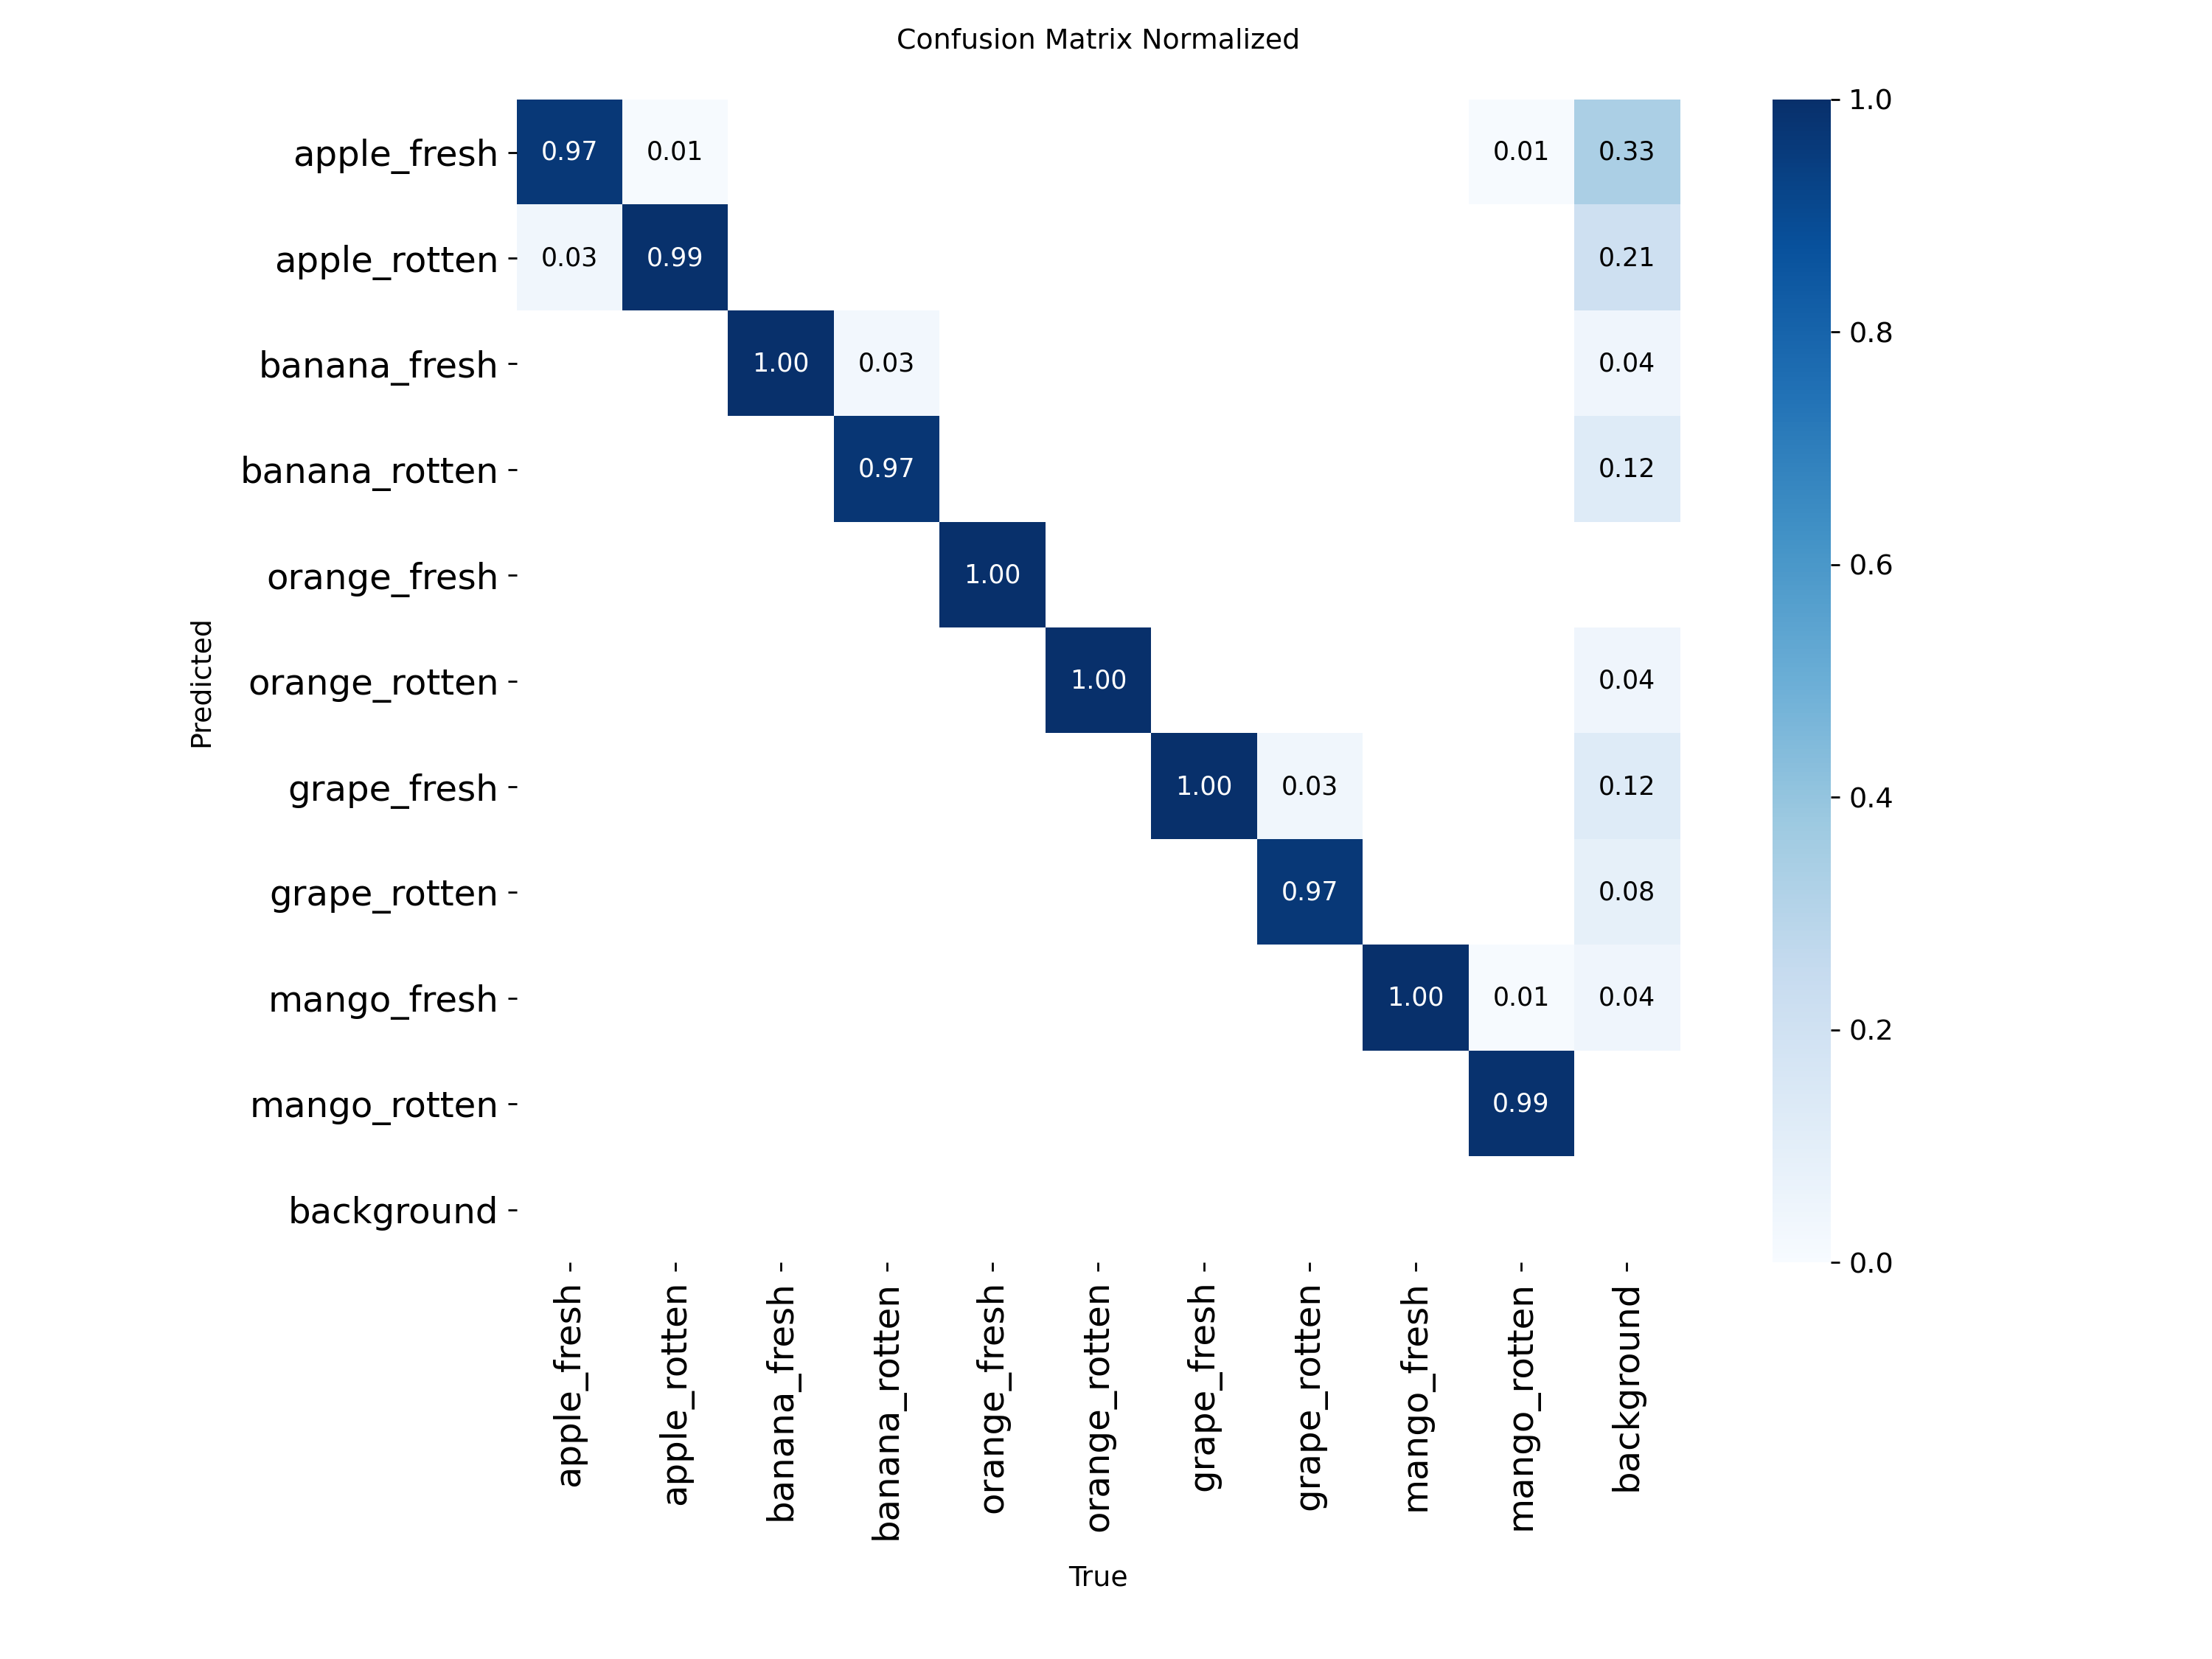

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train2/confusion_matrix_normalized.png')

##Prediction